In [ ]:
# %%
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plotting


In [25]:
# %%
# Load the dataset
data = pd.read_csv("/Users/rooj/Documents/RP3-Main/RP3-Data/CSE-CIC-IDS2018/DoS-Related/02-15-2018.csv")  # Update with your dataset's path

# Preview the data
print(data.head())
print(data.info())
print(data['Label'].value_counts())

   Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0         0         0  15/02/2018 08:25:18      112641158             3   
1        22         6  15/02/2018 08:29:05       37366762            14   
2     47514         6  15/02/2018 08:29:42            543             2   
3         0         0  15/02/2018 08:28:07      112640703             3   
4         0         0  15/02/2018 08:30:56      112640874             3   

   Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0             0                0                0                0   
1            12             2168             2993              712   
2             0               64                0               64   
3             0                0                0                0   
4             0                0                0                0   

   Fwd Pkt Len Min  ...  Fwd Seg Size Min  Active Mean     Active Std  \
0                0  ...                 0          0.0 

In [26]:
# %%
# Encode the Labels
label_mapping = {'Benign': 0, 'DoS attacks-GoldenEye': 1, 'DoS attacks-Slowloris': 2}
data['Label'] = data['Label'].map(label_mapping)

# Filter for relevant classes
data = data[data['Label'].isin([0, 1, 2])]
print("Encoded class distribution:\n", data['Label'].value_counts())

# %%
# Feature Selection
selected_features = [
    'Flow Duration', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Std', 
    'Pkt Size Avg', 'Flow IAT Mean'
]
X = data[selected_features]

Encoded class distribution:
 Label
0    996077
1     41508
2     10990
Name: count, dtype: int64


In [27]:
# %%
# Handle missing values
X = X.dropna()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# %%
# Apply PCA
pca = PCA(n_components=3)  # of components for visualization
X_pca = pca.fit_transform(X_scaled)
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

Explained variance ratio: [0.45608225 0.29048504 0.1203634 ]


/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

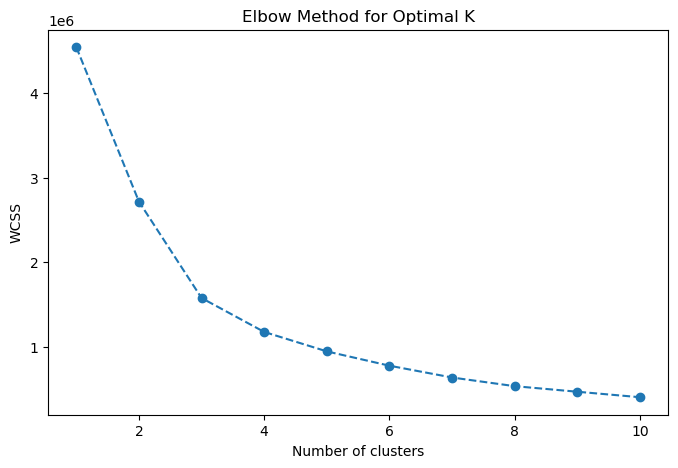

In [28]:
# %%
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [29]:
# %%
# From the Elbow plot, choose the optimal number of clusters, e.g., 3
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Add cluster labels to the original data
data['Cluster'] = cluster_labels

/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [30]:
sample_size = 10000
print(len(X_pca))

# Ensure the sample size does not exceed the dataset size
if len(X_pca) > sample_size:
    # Randomly select a subset of indices
    sample_indices = np.random.choice(len(X_pca), size=sample_size, replace=False)
    X_sample = X_pca[sample_indices]
    labels_sample = cluster_labels[sample_indices]
else:
    X_sample = X_pca
    labels_sample = cluster_labels

# Compute the Silhouette Score on the sample
sil_score = silhouette_score(X_sample, labels_sample)
print(f'Silhouette Score (sample of {len(X_sample)}): {sil_score}')

1048575
Silhouette Score (sample of 10000): 0.6979283809214152


In [ ]:

# %%
# Assuming X_pca is your PCA-transformed data and cluster_labels are the labels from K-Means
n_components = X_pca.shape[1]

if n_components == 2:
    # 2D Scatter Plot
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
    plt.title('2D PCA: Clusters after K-Means')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

elif n_components == 3:
    # 3D Scatter Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', s=50)
    ax.set_title('3D PCA: Clusters after K-Means')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
    ax.add_artist(legend1)
    plt.show()

else:
    print(f"Visualization for {n_components} components is not supported.")

# %%
# Analyze the composition of each cluster
cluster_composition = data.groupby('Cluster')['Label'].value_counts(normalize=True).unstack().fillna(0)
print(cluster_composition)

# %%
# Save the PCA and KMeans models for future use
import joblib
joblib.dump(pca, 'pca_model.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Models saved successfully.")